# Optic flow connectivity analysis in FAFB

This script is about getting optic flow vectors in the medulla based on the main inputs of direction-selective cells in the medulla

In [63]:
# Importing some packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# 1. Getting the data of interest

In [19]:
# Some user parameters
cell_of_interest = 'T4a'

In [18]:

dataPath = R'D:\Connectomics-Data\FlyWire\Visual-column-map'
fileName = 'ol_columns.csv.gz'
filePath = os.path.join(dataPath,fileName)
data = pd.read_csv(filePath, compression='gzip')

dataPath = R'D:\Connectomics-Data\FlyWire\Visual-column-map'
fileName = 'ol_metadata.csv.gz'
filePath = os.path.join(dataPath,fileName)
metadata = pd.read_csv(filePath, compression='gzip')

dataPath = R'D:\Connectomics-Data\FlyWire\Visual-column-map'
fileName = 'ol_connections.csv.gz'
filePath = os.path.join(dataPath,fileName)
connections = pd.read_csv(filePath, compression='gzip')

#Brief overview:
print('\n-------------------- data --------------------:\n')
print(data)
print('\n------------------ metadata ------------------:\n')
print(metadata)
print('\n----------------- connections ----------------:\n')
print(connections)


-------------------- data --------------------:

                  cell id cell type column id
0      720575940596125868       T5c        97
1      720575940599333574       Tm1       355
2      720575940599457990       T4b       247
3      720575940599459782       T5b       513
4      720575940599704006       T5a       331
...                   ...       ...       ...
23447  720575940661201025        R8       701
23448  720575940661224065       T4a       390
23449  720575940661245825        C3       183
23450  720575940661264001        C3        38
23451  720575940661284993        R8       694

[23452 rows x 3 columns]

------------------ metadata ------------------:

                 attribute    value
0   number of cells mapped    22578
1  synapses inside columns  1381915
2   synapses cross columns   811545

----------------- connections ----------------:

              from cell id          to cell id  synapses
0       720575940596125868  720575940622955561         2
1       720575

In [59]:
# Looking deeply at the match between individual cells and individual columns

cells_columns = data[data['cell type'] == cell_of_interest]
number_unique_cells = len(cells_columns['cell id'].unique())
number_unique_columns = len(cells_columns['column id'].unique())-1 #-1 to compensate for "not assigned label"

print(f'Total number of unique cells: {number_unique_cells}')
print(f'Total number of unique columns: {number_unique_columns}')
print(f'Missmatch: {number_unique_cells - number_unique_columns}')

# Identify duplicate values in 'column id'
duplicates = cells_columns[cells_columns.duplicated('column id', keep=False)]

print(f'Number of duplicates / cells not assigned to columns: {len(duplicates)}')

# Filter out rows with repetitive values
filtered_cells_columns = cells_columns[~cells_columns['column id'].isin(duplicates['column id'])]
print(f'Filtered data length: {len(filtered_cells_columns)}')
display(filtered_cells_columns.head())

Total number of unique cells: 737
Total number of unique columns: 725
Missmatch: 12
Number of duplicates / cells not assigned to columns: 12
Filtered data length: 725


,cell id,cell type,column id
7,720575940599755718,T4a,741
11,720575940600101641,T4a,487
13,720575940600143369,T4a,662
15,720575940600547529,T4a,727
54,720575940603491957,T4a,391


# 2. Creating the hexagonal grid

In [89]:
# Relevant custom made functions

def hexagon(x_center, y_center, size):
    """Returns the vertices of a hexagon centered at (x_center, y_center) with a given size."""
    angle = np.linspace(0, 2 * np.pi, 7)
    x_hexagon = x_center + size * np.cos(angle)
    y_hexagon = y_center + size * np.sin(angle)
    return x_hexagon, y_hexagon

def generate_hex_grid(rows, cols, size):
    """Generates hexagon centers and IDs, returns a DataFrame with the center coordinates and IDs."""
    hex_coord = []
    id_counter = 1
    
    for row in range(rows):
        for col in range(cols):
            x_offset = size * 3/2 * col
            y_offset = size * np.sqrt(3) * (row + 0.5 * (col % 2))
            hex_coord.append((x_offset, y_offset, id_counter))
            id_counter += 1
    
    hex_coord_df = pd.DataFrame(hex_coord, columns=['center_x', 'center_y', 'column_id'])
    return hex_coord_df



def plot_hex_grid(hex_coord_df, size):
    """Plots a hexagonal grid based on the DataFrame with hexagon centers and IDs."""
    plt.figure(figsize=(20, 20))
    
    for _, row in hex_coord_df.iterrows():
        x_hexagon, y_hexagon = hexagon(row['center_x'], row['center_y'], size)
        plt.fill(x_hexagon, y_hexagon, edgecolor='black', facecolor='lightblue')
        plt.text(row['center_x'], row['center_y'], str(int(row['column_id'])), ha='center', va='center', fontsize=5, weight='bold')
    
    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.show()

def plot_hex_grid(hex_coord_df, size):
    """Plots a hexagonal grid based on the DataFrame with hexagon centers and IDs."""
    plt.figure(figsize=(10, 10))
    
    # Calculate a suitable font size based on the hexagon size
    base_font_size = 12
    font_size = base_font_size * size / 2
    
    for _, row in hex_coord_df.iterrows():
        x_hexagon, y_hexagon = hexagon(row['center_x'], row['center_y'], size)
        plt.fill(x_hexagon, y_hexagon, edgecolor='black', facecolor='lightblue')
        plt.text(row['center_x'], row['center_y'], str(int(row['column_id'])), ha='center', va='center', 
                 fontsize=font_size, weight='bold')
    
    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.show()



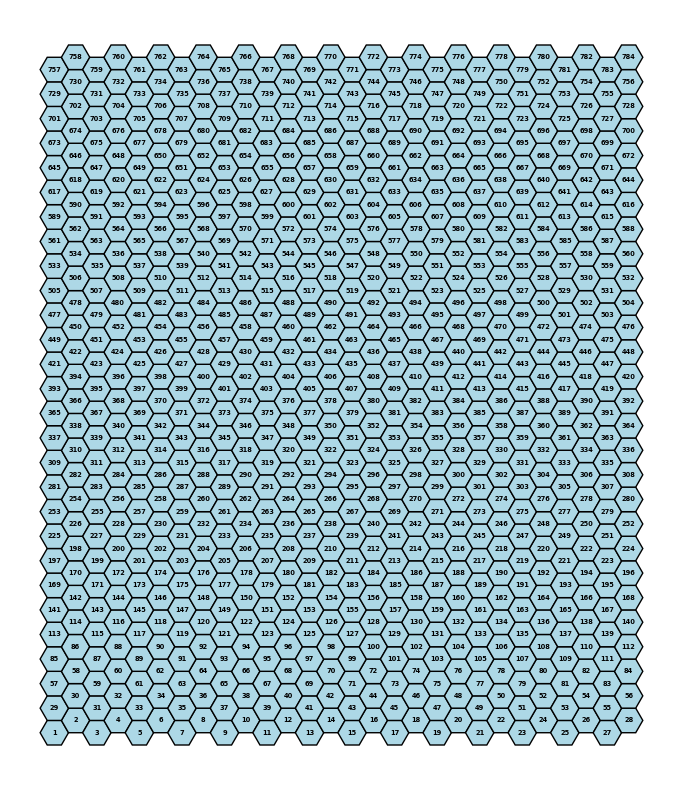

     center_x   center_y  column_id
0         0.0   0.000000          1
1         1.2   0.692820          2
2         2.4   0.000000          3
3         3.6   0.692820          4
4         4.8   0.000000          5
..        ...        ...        ...
779      27.6  38.105118        780
780      28.8  37.412297        781
781      30.0  38.105118        782
782      31.2  37.412297        783
783      32.4  38.105118        784

[784 rows x 3 columns]


In [90]:
## Generating and plotting the hexagonal grid

# Parameters
rows = 28  # Number of rows in the hexagonal grid
cols = 28  # Number of columns in the hexagonal grid
size = 0.8  # Size of each hexagon

# Generate the hex grid DataFrame
hex_grid_df = generate_hex_grid(rows, cols, size)

# Plot the hex grid based on the DataFrame
plot_hex_grid(hex_grid_df, size)

# Display the DataFrame
print(hex_grid_df)

In [85]:
28*28


784